# Random forest for pianist classification

## Import dependencies, set constants etc.

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from joblib import Parallel, delayed
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.inspection._permutation_importance import _weights_scorer, _create_importances_bunch
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import check_scoring
from sklearn.model_selection import StratifiedKFold, ParameterSampler, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import check_random_state
from statsmodels.stats.outliers_influence import variance_inflation_factor

import src.visualise.visualise_utils as vutils
from src import utils
from src.detect.detect_utils import OnsetMaker
from src.features.features_utils import PhaseCorrection, BeatUpbeatRatio, IOIComplexity, TempoSlope, ProportionalAsynchrony, RollingIOISummaryStats
from src.visualise.random_forest_plots import *

In [2]:
# These variables are used for the optimization process
SEED = 42
N_FOLDS = 5
N_JOBS = -1
# Number of iterations to use in random sampling
N_ITER = 10000

In [3]:
# Set the seed in NumPy for consistent results across function calls
np.random.seed(SEED)

## Define predictor and prediction variables, get mappings

In [4]:
# Define target/prediction variables
EXOG_INS = 'piano'
PREDICTION = 'pianist'

In [5]:
# These are the underlying categories each predictor belongs to
PREDICTORS_CATEGORIES = {
    'Swing': ['bur_log_mean', 'bur_log_std'],
    'Complexity': ['lz77_mean', 'lz77_std', 'n_onsets_mean', 'n_onsets_std'],
    'Feel': ['bass_prop_async_nanmean', 'drums_prop_async_nanmean', 'bass_prop_async_nanstd', 'drums_prop_async_nanstd'],
    'Interaction': ['self_coupling', 'coupling_drums', 'coupling_bass', 'coupling_piano_drums', 'coupling_piano_bass'],
    'Tempo': ['rolling_std_median', 'tempo', 'tempo_slope',]
}
PREDICTORS = [it for sl in list(PREDICTORS_CATEGORIES.values()) for it in sl]

In [6]:
# This creates a dictionary for mapping a predictor onto its category
CATEGORY_MAPPING = {}
for pred in PREDICTORS:
    for category in PREDICTORS_CATEGORIES.keys():
        if pred in PREDICTORS_CATEGORIES[category]:
            CATEGORY_MAPPING[pred] = category

## Load in data

First, we load in our list of `src.detect.detect_utils.OnsetMaker` classes. These contain the location of detected onsets and beats, as well as additional metadata.

In [7]:
onsets: list[OnsetMaker] = utils.unserialise_object(fr'{utils.get_project_root()}\models\matched_onsets_corpus_chronology')

## Extract features

Now, we can extract our desired feature from each OnsetMaker class.

In [8]:
def get_feature_data(feature_cls, cols, extra_str = '', **cls_kwargs):
    """Creates a class with given kwargs and returns the desired key-value pairs from its summary dictionary"""
    cls = feature_cls(**cls_kwargs)
    return {k + extra_str: v for k, v in cls.summary_dict.items() if k in cols}

In [9]:
def process_track(track: OnsetMaker) -> dict:
    """Processes a single track, extracting all required features, and returns a dictionary"""
    # Convert the summary dictionary (dictionary of arrays) to a dataframe
    summary_dict = pd.DataFrame(track.summary_dict)
    # These are the positions of downbeats, i.e. the first beat of a measure
    downbeats = track.ons['downbeats_manual']
    # The tempo and time signature of the track
    tempo = track.tempo
    time_signature = track.item['time_signature']
    # Subset to get my onsets and partner onsets as separate dataframes
    my_onsets = track.ons[EXOG_INS]
    my_beats = summary_dict[EXOG_INS]
    their_beats = summary_dict[[i for i in utils.INSTRUMENTS_TO_PERFORMER_ROLES.keys() if i != EXOG_INS]]
    # BEAT-UPBEAT RATIO
    bur = get_feature_data(
        BeatUpbeatRatio, ['bur_log_mean', 'bur_log_std', 'bur_log_count_nonzero'],
        my_onsets=my_onsets, my_beats=my_beats, clean_outliers=True
    )
    # PHASE CORRECTION
    pc = get_feature_data(
        PhaseCorrection, ['self_coupling', 'coupling_bass', 'coupling_drums', 'nobs'],
        my_beats=my_beats, their_beats=their_beats, order=1
    )
    # PHASE CORRECTION - PARTNER
    # In comparison to the 'full' phase correction model, we only need to get a few columns here
    pcb = get_feature_data(
        PhaseCorrection, ['coupling_piano', 'nobs'], extra_str='_bass',
        my_beats=summary_dict['bass'], their_beats=summary_dict[['piano', 'drums']], order=1
    )
    pcd = get_feature_data(
        PhaseCorrection, ['coupling_piano', 'nobs'], extra_str='_drums',
        my_beats=summary_dict['drums'], their_beats=summary_dict[['piano', 'bass']], order=1
    )
    # PROPORTIONAL ASYNCHRONY
    pa = get_feature_data(
        ProportionalAsynchrony, ['prop_async_count_nonzero', 'bass_prop_async_nanmean', 'drums_prop_async_nanmean', 'bass_prop_async_nanstd', 'drums_prop_async_nanstd'],
        summary_df=summary_dict, my_instr_name=EXOG_INS
    )
    # IOI COMPLEXITY
    ioi = get_feature_data(
        IOIComplexity, ['lz77_mean', 'lz77_std', 'n_onsets_mean', 'n_onsets_std', 'window_count', 'ioi_count'],
        my_onsets=my_onsets, downbeats=downbeats, tempo=tempo, time_signature=time_signature
    )
    # TEMPO SLOPE
    ts = get_feature_data(
        TempoSlope, ['tempo_slope', 'tempo_drift'],
        my_beats=pd.concat([my_beats, their_beats], axis=1).mean(axis=1)
    )
    # TEMPO STABILITY
    tstab = get_feature_data(
        RollingIOISummaryStats, ['rolling_std_count_nonzero', 'rolling_std_median'],
        my_onsets=my_beats, downbeats=downbeats, bar_period=4
    )
    # Return a single dictionary that combines the summary dictionary for all the features
    return dict(**track.item, **bur, **pc, **pcb, **pcd, **pa, **ioi, **ts, **tstab, tempo=tempo)

Now, we extract features from all tracks in parallel (should take < 5 minutes)

In [10]:
with Parallel(n_jobs=-1, verbose=5) as parallel:
    res = parallel(delayed(process_track)(t) for t in onsets)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   37.0s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.6min finished


We can now convert all of these features to a dataframe, sort by the pianist in the recording, and print a few rows.

In [11]:
df = pd.DataFrame(res).sort_values('pianist').reset_index(drop=True)

In [12]:
print(df.head())

                      track_name  \
0                 Poor Butterfly   
1                    Tranquility   
2                  Where Are You   
3  I Didnt Know What Time It Was   
4               Waltz for Debbie   

                                          album_name recording_year  \
0          Complete Live at the Pershing Lounge 1958           1958   
1                                        Tranquility           1967   
2                          In Search of Momentum 110           2002   
3  Emerald City Nights Live At The Penthouse 1965...           1966   
4                                     Live at Bubbas           1980   

       pianist channel_overrides                                mbz_id  \
0  Ahmad Jamal                {}  94f90cba-f3c7-4a05-b86a-e30fd9ebe989   
1  Ahmad Jamal     {'bass': 'l'}  4cc954d6-1e00-4bfd-b0e3-d12d2b5f853b   
2  Ahmad Jamal                {}  a1295aa8-78ab-4234-a8a9-f05c1916d2d8   
3  Ahmad Jamal                {}  d41671ba-f977-41b4-8108-8c

## Plot correlations between features
Before we clean outliers, we should plot the correlations between the raw values

In [13]:
df[PREDICTORS].isna().sum()

bur_log_mean                 2
bur_log_std                  2
lz77_mean                    2
lz77_std                     2
n_onsets_mean                2
n_onsets_std                 2
bass_prop_async_nanmean     11
drums_prop_async_nanmean     2
bass_prop_async_nanstd      12
drums_prop_async_nanstd      3
self_coupling               19
coupling_drums              19
coupling_bass               19
coupling_piano_drums        18
coupling_piano_bass         21
rolling_std_median           2
tempo                        0
tempo_slope                  0
dtype: int64

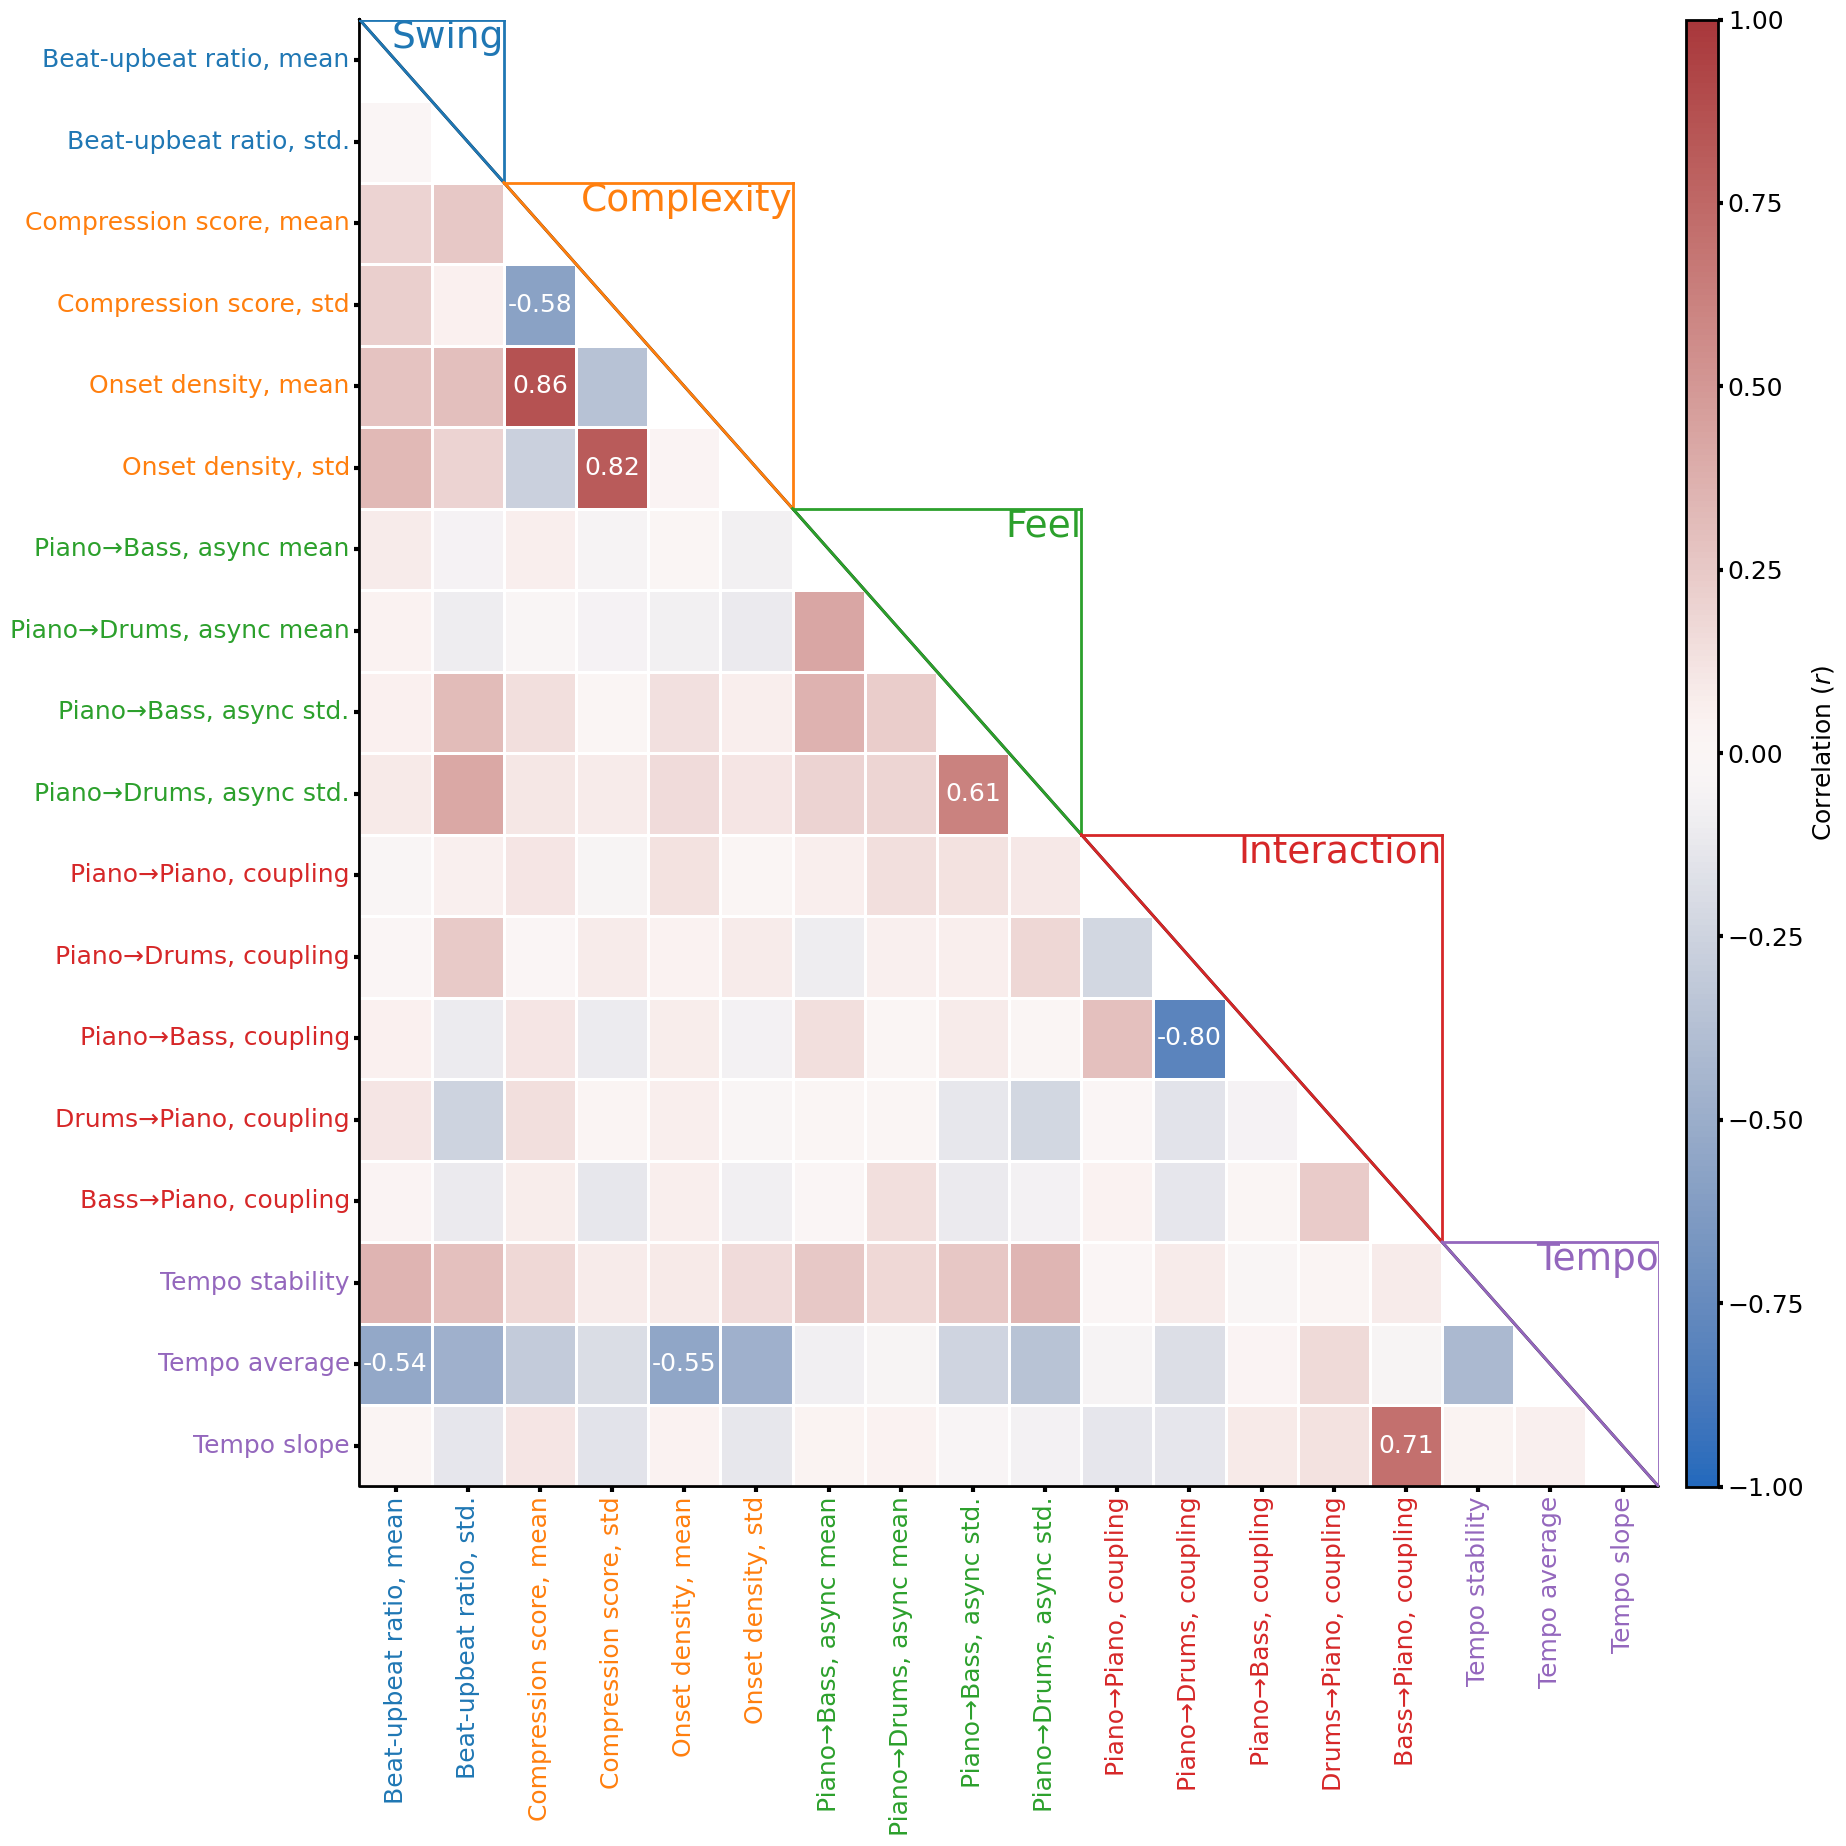

In [14]:
HeatMapFeatureCorrelation(df[PREDICTORS]).create_plot()
plt.show()

## Clean dataset
### Identify outliers
When cleaning the dataset, we first need to identify outlying values in our features. We set outlying values to `np.nan` so that we can set them to the overall average later, rather than removing the track completely. To start, we clean `self_coupling`, `coupling_bass`, or `coupling_drums` when `nobs < 30`: this means that we have fewer than 10 terms for each of our 3 predictors in the regression.

In [15]:
clean = df.copy(deep=True)

In [16]:
for col in ['self_coupling', 'coupling_bass', 'coupling_drums']:
    # If we have NaN obs, it's because the model failed to compile, so replace this with 0
    clean[f'nobs'] = clean[f'nobs'].fillna(0)
    clean.loc[clean['nobs'] < 30, col] = np.nan

For the same reason, we clean `coupling_bass_piano` (i.e. bass coupling to piano) when `nobs_bass < 30` (sim. for `coupling_drums_piano` and `nobs_drums`)

In [17]:
for col in ['bass', 'drums']:
    # If we have NaN obs, it's because the model failed to compile, so replace this with 0
    clean[f'nobs_{col}'] = clean[f'nobs_{col}'].fillna(0)
    clean.loc[clean[f'nobs_{col}'] < 30, f'coupling_piano_{col}'] = np.nan

We clean `bur_log_mean` and `bur_log)std` when `-2 <= average_bur <= 2` (these are the values discussed by Corcoran and Frieler) OR `bur_log_count_nonzero < 15` (we have fewer than 15 BURs in the track).

In [18]:
for col in ['bur_log_mean', 'bur_log_std']:
    clean.loc[clean['bur_log_mean'] < -2, col] = np.nan
    clean.loc[clean['bur_log_mean'] > 2, col] = np.nan
    clean.loc[clean['bur_log_count_nonzero'] < 15, col] = np.nan

We clean `bass/drums_prop_async` when `piano_prop_async_count_nonzero < 15`, i.e. we have fewer than 15 beat asynchronies

In [19]:
for col in ['bass', 'drums']:
    clean.loc[clean['prop_async_count_nonzero'] < 10, f'{col}_prop_async_nanmean'] = np.nan
    clean.loc[clean['prop_async_count_nonzero'] < 10, f'{col}_prop_async_nanstd'] = np.nan

We clean `tempo_slope` and `tempo_drift` when `tempo_slope.abs() < 0.15`, i.e. we accelerated (or decelerated) by more than 0.15 beats-per-minute-per-second. This is the upper limit of values suggested to be realistic for jazz ensembles in the control condition of our previous experiment.

In [20]:
clean.loc[clean['tempo_slope'].abs() > 0.15, 'tempo_slope'] = np.nan
clean.loc[clean['tempo_slope'].abs() > 0.15, 'tempo_drift'] = np.nan

We clean `rolling_std_median` when `rolling_std_median > 0.4`, i.e. the median standard deviation for a four-second window of 1/4 note beats is greater than 40 milliseconds. This is the upper limit of values for this variable from our earlier experiment.

In [21]:
clean.loc[clean['rolling_std_median'] > 0.4, 'rolling_std_median'] = np.nan

## Get number of missing values per predictor
Let's see how many missing values we have per predictor variable

In [22]:
COL_MAPPING = {
    'bur_log_mean': 'Beat-upbeat ratio, mean',
    'bur_log_std': 'Beat-upbeat ratio, std.',
    'lz77_mean': 'Compression score, mean',
    'lz77_std': 'Compression score, std',
    'n_onsets_mean': 'Onset density, mean',
    'n_onsets_std': 'Onset density, std',
    'bass_prop_async_nanmean': 'Piano→Bass, async mean',
    'bass_prop_async_nanstd': 'Piano→Bass, async std.',
    'drums_prop_async_nanmean': 'Piano→Drums, async mean',
    'drums_prop_async_nanstd': 'Piano→Drums, async std.',
    'coupling_bass': 'Piano→Bass, coupling',
    'coupling_piano_bass': 'Bass→Piano, coupling',
    'coupling_drums': 'Piano→Drums, coupling',
    'coupling_piano_drums': 'Drums→Piano, coupling',
    'self_coupling': 'Piano→Piano, coupling',
    'rolling_std_median': 'Tempo stability',
    'tempo': 'Tempo average',
    'tempo_slope': 'Tempo slope',
}

In [23]:
miss = clean[PREDICTORS].isna().sum().reset_index()
miss['cat'] = miss['index'].map(CATEGORY_MAPPING)
print(miss)

                       index    0          cat
0               bur_log_mean   15        Swing
1                bur_log_std   15        Swing
2                  lz77_mean    2   Complexity
3                   lz77_std    2   Complexity
4              n_onsets_mean    2   Complexity
5               n_onsets_std    2   Complexity
6    bass_prop_async_nanmean   12         Feel
7   drums_prop_async_nanmean    3         Feel
8     bass_prop_async_nanstd   12         Feel
9    drums_prop_async_nanstd    3         Feel
10             self_coupling  128  Interaction
11            coupling_drums  128  Interaction
12             coupling_bass  128  Interaction
13      coupling_piano_drums   71  Interaction
14       coupling_piano_bass   95  Interaction
15        rolling_std_median    8        Tempo
16                     tempo    0        Tempo
17               tempo_slope   24        Tempo


In [24]:
print(miss.groupby('cat')[0].mean() / 300)

cat
Complexity     0.006667
Feel           0.025000
Interaction    0.366667
Swing          0.050000
Tempo          0.035556
Name: 0, dtype: float64


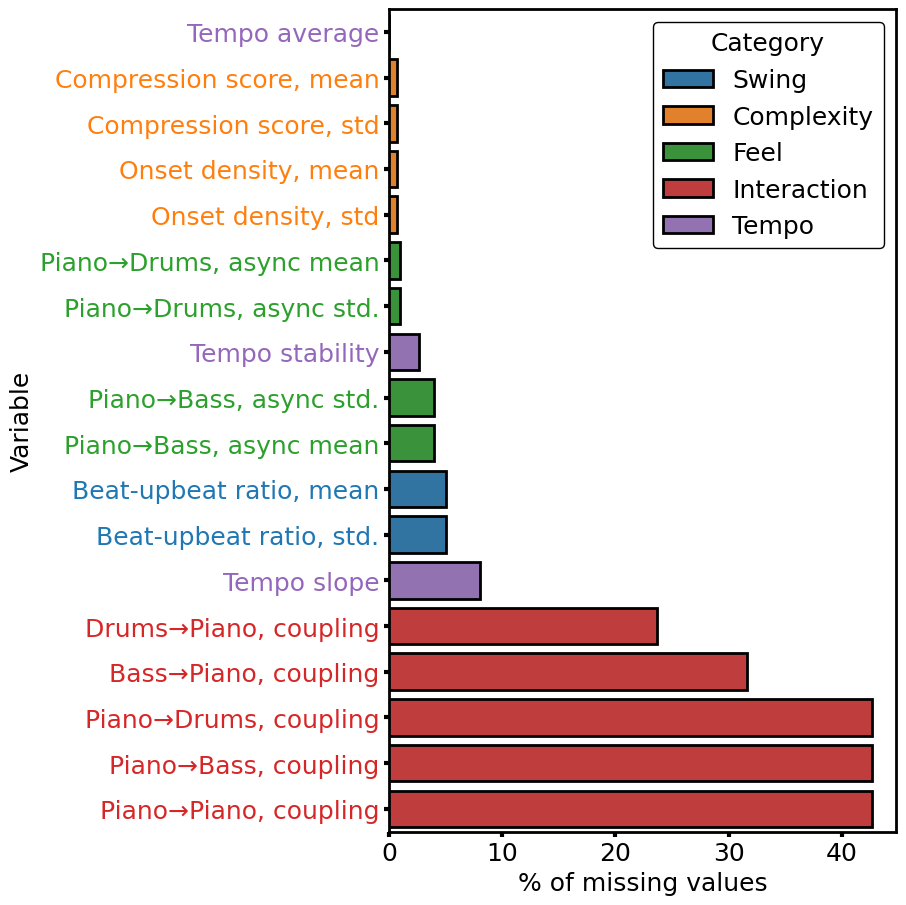

In [25]:
CountPlotMissingValues(clean[PREDICTORS], CATEGORY_MAPPING).create_plot()
plt.show()

### Impute missing values based on feature average
We can now set missing values to the average for that feature across the entire dataset.

In [26]:
X = clean[PREDICTORS].fillna(clean[PREDICTORS].mean())

In [27]:
X.corr()

,bur_log_mean,bur_log_std,lz77_mean,lz77_std,n_onsets_mean,n_onsets_std,bass_prop_async_nanmean,drums_prop_async_nanmean,bass_prop_async_nanstd,drums_prop_async_nanstd,self_coupling,coupling_drums,coupling_bass,coupling_piano_drums,coupling_piano_bass,rolling_std_median,tempo,tempo_slope
bur_log_mean,1.000000,0.018120,0.082715,0.204238,0.226131,0.297831,0.114162,0.036279,0.066406,0.113081,0.060446,0.118495,-0.005110,-0.113854,-0.000291,0.280378,-0.589054,-0.129564
bur_log_std,0.018120,1.000000,0.255293,0.050245,0.314702,0.220821,-0.052244,-0.100675,0.311556,0.414808,0.171244,0.215781,0.069454,-0.231379,-0.182571,0.241390,-0.507515,-0.237513
lz77_mean,0.082715,0.255293,1.000000,-0.582117,0.861500,-0.268689,0.076048,-0.035046,0.136428,0.099194,0.053057,0.147420,-0.048267,-0.098009,-0.051004,0.263386,-0.301522,0.052998
lz77_std,0.204238,0.050245,-0.582117,1.000000,-0.365285,0.815524,-0.046882,-0.070843,0.008033,0.079786,0.085757,0.020402,-0.009943,-0.013879,-0.010720,0.017084,-0.192703,-0.133105
n_onsets_mean,0.226131,0.314702,0.861500,-0.365285,1.000000,0.023730,0.011558,-0.088717,0.136169,0.155745,0.115969,0.203515,-0.066836,-0.079407,-0.056865,0.148304,-0.552648,-0.035297
n_onsets_std,0.297831,0.220821,-0.268689,0.815524,0.023730,1.000000,-0.070061,-0.125504,0.063671,0.111693,0.109569,0.087607,-0.064340,-0.071587,-0.043647,0.086381,-0.481210,-0.191055
bass_prop_async_nanmean,0.114162,-0.052244,0.076048,-0.046882,0.011558,-0.070061,1.000000,0.422543,0.366270,0.193774,0.016178,-0.066147,0.149305,-0.106844,-0.060109,0.291059,-0.080852,-0.089086
drums_prop_async_nanmean,0.036279,-0.100675,-0.035046,-0.070843,-0.088717,-0.125504,0.422543,1.000000,0.228394,0.192800,0.014833,-0.031501,0.030995,-0.119702,-0.106059,0.185899,-0.043930,-0.141394
bass_prop_async_nanstd,0.066406,0.311556,0.136428,0.008033,0.136169,0.063671,0.366270,0.228394,1.000000,0.589656,0.155206,0.077507,0.225267,-0.341522,-0.382695,0.275559,-0.244437,-0.249679
drums_prop_async_nanstd,0.113081,0.414808,0.099194,0.079786,0.155745,0.111693,0.193774,0.192800,0.589656,1.000000,0.138755,0.254064,0.009367,-0.428103,-0.318067,0.310387,-0.357435,-0.176553


Let's check that we've filled all missing values

In [28]:
print(X.isna().values.any())

False


### Encode categorical prediction variable
Next, we need to encode our predictor variable (currently a list of names) to integers.

In [29]:
# We can store the labels for later use
pianist_labels = clean[PREDICTION].unique().tolist()
y = clean[PREDICTION].map({val: i for i, val in enumerate(pianist_labels)})

## Random Forest modelling (new)
### Create the model class

In [30]:
PREDICTORS_CATEGORIES

{'Swing': ['bur_log_mean', 'bur_log_std'],
 'Complexity': ['lz77_mean', 'lz77_std', 'n_onsets_mean', 'n_onsets_std'],
 'Feel': ['bass_prop_async_nanmean',
  'drums_prop_async_nanmean',
  'bass_prop_async_nanstd',
  'drums_prop_async_nanstd'],
 'Interaction': ['self_coupling',
  'coupling_drums',
  'coupling_bass',
  'coupling_piano_drums',
  'coupling_piano_bass'],
 'Tempo': ['rolling_std_median', 'tempo', 'tempo_slope']}

In [31]:
class RandomForestFit:
    """Provides a wrapper around `StratifiedKFold` and `RandomForestClassifier`"""
    col_idxs = [[0, 1], [2, 3, 4, 5], [6, 7, 8, 9], [10, 11, 12, 13, 14], [15, 16, 17]]

    def __init__(self, params: dict = None):
        self.params = params if params is not None else {}
        # I think we can probably shuffle the data first.
        # The data is unordered (not time-series), so unlikely to have a negative effect
        self.skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)
        self.predicts, self.importances, self.grouped_importances = [], [], []
        self.trees = []

    def fit_model(self, x_data, y_data):
        fits = [self._fit_model(x_data, y_data, x_idx, y_idx) for x_idx, y_idx in self.skf.split(x_data, y_data)]
        predicts, feature_importances, grouped_importance = list(zip(*fits))
        self.predicts = self._format_predicts_df(predicts)
        self.importances = self._format_importances_df(feature_importances)
        self.grouped_importances = pd.concat(grouped_importance, axis=1)
        return self

    def get_global_accuracy(self) -> float:
        """Returns the percentage of correct predictions"""
        return self.predicts['correct'].value_counts(normalize=True)[True]

    @staticmethod
    def _format_importances_df(importances) -> pd.DataFrame:
        importances_df_ = (
            pd.concat(importances, axis=1)
            .reset_index(drop=False)
            .rename(columns={'index': 'feature'})
        )
        importances_df_['category'] = importances_df_['feature'].map(CATEGORY_MAPPING)
        return importances_df_

    @staticmethod
    def _format_predicts_df(predicts) -> pd.DataFrame:
        predict_df_ = (
            pd.concat(predicts, axis=0)
            .sort_index()
            .rename(columns={0: 'prediction', 'pianist': 'actual'})
        )
        predict_df_['correct'] = predict_df_['prediction'] == predict_df_['actual']
        for var in ['prediction', 'actual']:
            predict_df_[var] = predict_df_[var].map({i: val for i, val in enumerate(pianist_labels)})
        return predict_df_

    def _fit_model(self, x_data, y_data, train_idx, test_idx):
        # Get our splits for this fold
        X_train, X_test = x_data.iloc[train_idx], x_data.iloc[test_idx]
        y_train, y_test = y_data[train_idx], y_data[test_idx]
        # Create the random forest model
        rf = RandomForestClassifier(random_state=SEED, **self.params)
        # Fit the random forest to the training data
        rf.fit(X_train, y_train)
        self.trees.append(rf)
        # Predict the test data
        y_predict = rf.predict(X_test)
        # Get prediction probabilities
        y_probs = rf.predict_proba(X_test)
        # Calculate importance of individual features
        fpi = self.permutation_importance(rf, X_test, y_test)
        # Calculate importance of feature groups
        gpi = self.grouped_permutation_importance(rf, X_test, y_test)
        # Return the prediction and feature importance dataframes
        return (
            self._format_predict_df(y_predict, y_probs, y_test),
            pd.DataFrame(fpi.importances, index=X.columns),
            pd.DataFrame(gpi.importances, index=PREDICTORS_CATEGORIES.keys())
        )

    @staticmethod
    def permutation_importance(
            estimator, X: pd.DataFrame, y: pd.DataFrame, n_repeats: int = 10,
            scoring: str = 'accuracy', sample_weight: float = None, max_samples: float = 1.0
    ) -> dict:
        return permutation_importance(
            estimator, X, y, n_repeats=n_repeats, random_state=SEED, n_jobs=N_JOBS,
            sample_weight=sample_weight, max_samples=max_samples, scoring=scoring
        )

    @staticmethod
    def _format_predict_df(predict, predict_probs, actual):
        y_probs = pd.DataFrame(predict_probs)
        y_probs.columns = y_probs.columns.map({i: val for i, val in enumerate(pianist_labels)})
        y_probs.index = actual.index
        # Format the prediction series
        y_predict_s = pd.Series(predict)
        y_predict_s.index = actual.index
        # Concatenate the predicted and actual pianist
        return pd.concat([y_predict_s, actual, y_probs], axis=1)

    @staticmethod
    def _grouped_permutation_score(
        estimator, X, y, sample_weight, col_idxs,
        random_state, n_repeats, scorer,
    ):
        random_state = check_random_state(random_state)
        X_permuted = X.copy()
        scores = []
        shuffling_idx = np.arange(X_permuted.shape[0])
        for _ in range(n_repeats):
            random_state.shuffle(shuffling_idx)
            col = X_permuted.iloc[shuffling_idx, col_idxs]
            col.index = X_permuted.index
            X_permuted[X_permuted.columns[col_idxs]] = col
            scores.append(_weights_scorer(scorer, estimator, X_permuted, y, sample_weight))
        return np.array(scores)

    def grouped_permutation_importance(
            self, estimator, X: pd.DataFrame, y: pd.DataFrame, random_state: float = SEED,
            n_repeats: int = 10, scoring: str = 'accuracy', sample_weight: float = None
    ) -> dict:
        random_state = check_random_state(random_state)
        random_seed = random_state.randint(np.iinfo(np.int32).max + 1)
        scorer = check_scoring(estimator, scoring)
        baseline_score = _weights_scorer(scorer, estimator, X, y, sample_weight)
        scores2 = [self._grouped_permutation_score(
            estimator=estimator, X=X, y=y, col_idxs=col_idx, random_state=random_seed,
            n_repeats=n_repeats, scorer=scorer, sample_weight=sample_weight,
        ) for col_idx in self.col_idxs]
        return _create_importances_bunch(baseline_score, np.array(scores2))


### Get baseline accuracy
Here, we just guess a random pianist for each track

In [32]:
accuracy_random = accuracy_score(y, np.random.randint(y.min(), y.max(), len(y)))
print(f"Random guess accuracy: {accuracy_random}")

Random guess accuracy: 0.1


As you'd expect with 10 pianists and 30 tracks per pianist, we'll be correct approximately one in ten times if we just guess the pianist at random.

### Fit the initial model and get accuracy
Here we just use the default parameters for fitting the model

In [101]:
rf_init = RandomForestFit().fit_model(X, y)
print(f'Initial model accuracy: {rf_init.get_global_accuracy()}')

Initial model accuracy: 0.49333333333333335


### Parameter optimization
Now, we can try and optimize the model using a randomized search over an array of parameters

In [32]:
# These are the parameters we'll sample from when optimizing
test_params = dict(
    # The number of trees to grow in the forest
    n_estimators=[i for i in range(10, 1001, 1)],
    # Max number of features considered for splitting a node
    max_features=[None, 'sqrt', 'log2'],
    # Max number of levels in each tree
    max_depth=[None, *[i for i in range(1, 101, 1)]],
    # Minimum number of samples required to split a node
    min_samples_split=[i for i in range(2, 11)],
    # Minimum number of samples required at each leaf node
    min_samples_leaf=[i for i in range(1, 11)],
    # Whether to sample data points with our without replacement
    bootstrap=[True, False],
)

In [33]:
# Create the `ParameterSampler` object for the required number of iterations
sampler = ParameterSampler(test_params, n_iter=N_ITER, random_state=SEED)

In [30]:
def get_cached_tracks() -> list:
    """Tries to get cached optimised parameters, returns an empty list if cannot find"""
    try:
        return utils.load_csv(
            fpath=rf"{utils.get_project_root()}\references\parameter_optimisation\corpus_chronology",
            fname='random_forest_opt'
        )
    except FileNotFoundError:
        return []

In [33]:
def create_forest(parameters: dict, iteration: int,):
    """Conducts one iteration of parameter optimisation, with given parameter"""
    # Check our cache to see if we've already got results for this iteration
    # As we use a set seed with `ParameterSampler`, we can get results with just the counter
    cached_results = get_cached_tracks()
    try:
        cached_res = [o for o in cached_results if o['iteration'] == iteration][0]
        # assert all(k in cached_res and parameters[k] == cached_res[k] for k in to_check)
    except (IndexError, AssertionError):
        pass
    else:
        return cached_res

    # Create the forest model
    forest = RandomForestFit(params=parameters)
    # Fit the model to the data
    forest.fit_model(X, y)
    # Create the results dictionary and save
    results_dict = {
        'accuracy': forest.get_global_accuracy(),
        'iteration': iteration,
        **parameters
    }
    utils.save_csv(
        results_dict,
        rf"{utils.get_project_root()}\references\parameter_optimisation\corpus_chronology",
        'random_forest_opt'
    )
    # Return the fitted forest object
    return results_dict

In [ ]:
# Use lazy parallelization to create the forest and fit to the data
with Parallel(n_jobs=N_JOBS, verbose=11) as parallel:
    rfs_fitted = parallel(delayed(create_forest)(params, num) for num, params in enumerate(sampler))

### Get the optimized parameters

In [ ]:
# Create a dataframe of parameters and accuracy scores
opt_df = pd.DataFrame(rfs_fitted)
opt_df.head()

In [ ]:
# Get the parameter combination that yielded the best accuracy
best_params = opt_df[opt_df['accuracy'] == opt_df['accuracy'].max()][test_params.keys()].to_dict('records')[0]
best_params['max_depth'] = int(best_params['max_depth'])

So the optimization process doesn't have to be re-run each time, the final parameter set is given below in plain text:

`{
    'n_estimators': 50,
    'max_features': 'log2',
    'max_depth': 30,
    'bootstrap': True,
    'min_samples_leaf': 1,
    'min_samples_split': 2
 }`

### Fit the optimized model and get accuracy
Now, we use the best combination of parameters from our optimization process

In [33]:
BEST_PARAMS = {'n_estimators': 50, 'max_features': 'log2', 'max_depth': 30, 'bootstrap': True, 'min_samples_leaf': 1, 'min_samples_split': 2}

In [34]:
rf_opt = RandomForestFit(params=BEST_PARAMS).fit_model(X, y)
print(f'Optimized model accuracy: {rf_opt.get_global_accuracy()}')

Optimized model accuracy: 0.52


## Plot results
### Plot feature importance
Which rhythmic features are most important in defining the personal style of a particular pianist?

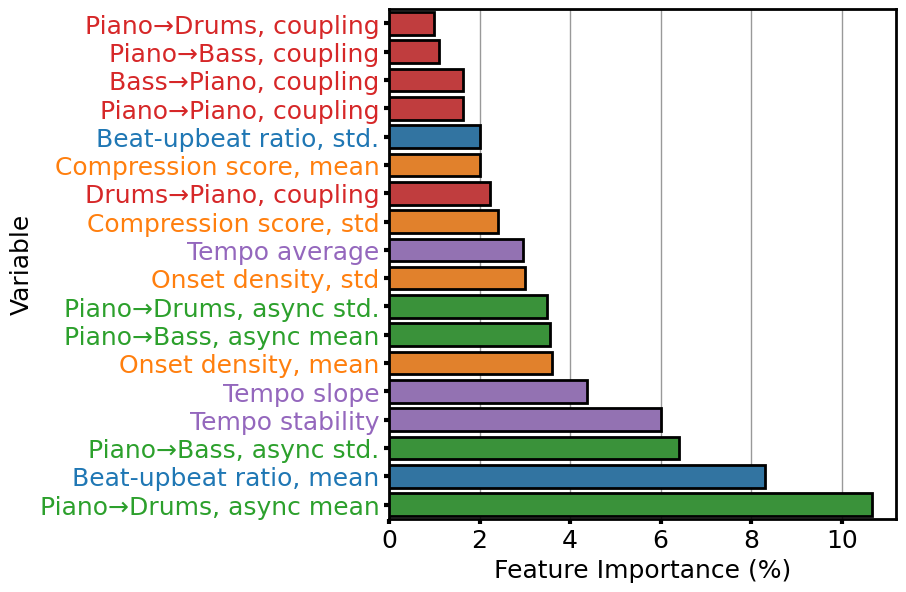

In [35]:
BarPlotFeatureImportances(rf_opt.importances).create_plot()
plt.show()

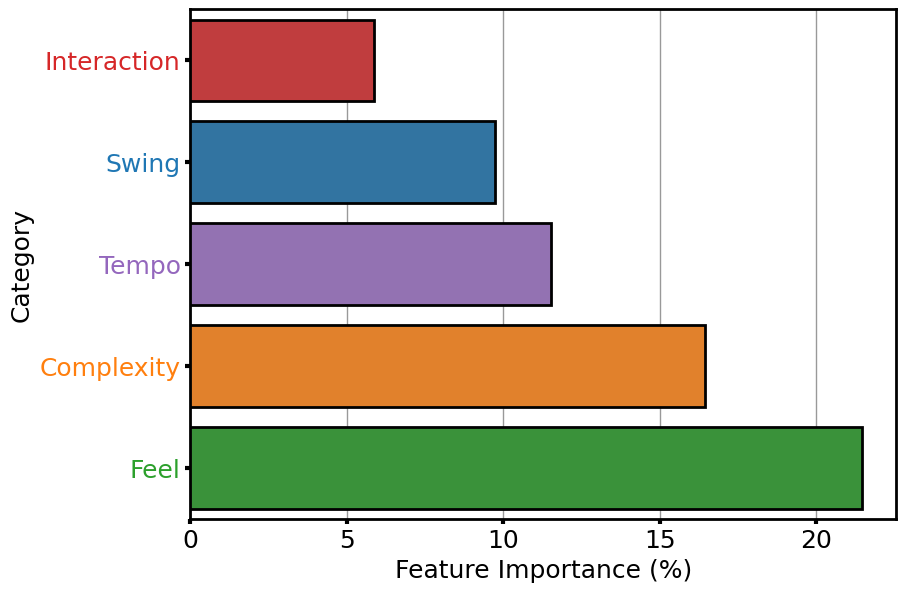

In [36]:
BarPlotCategoryImportances(rf_opt.grouped_importances).create_plot()
plt.show()

### Plot prediction errors by pianist
Which pianist's style is easiest to predict based on rhythmic features alone?

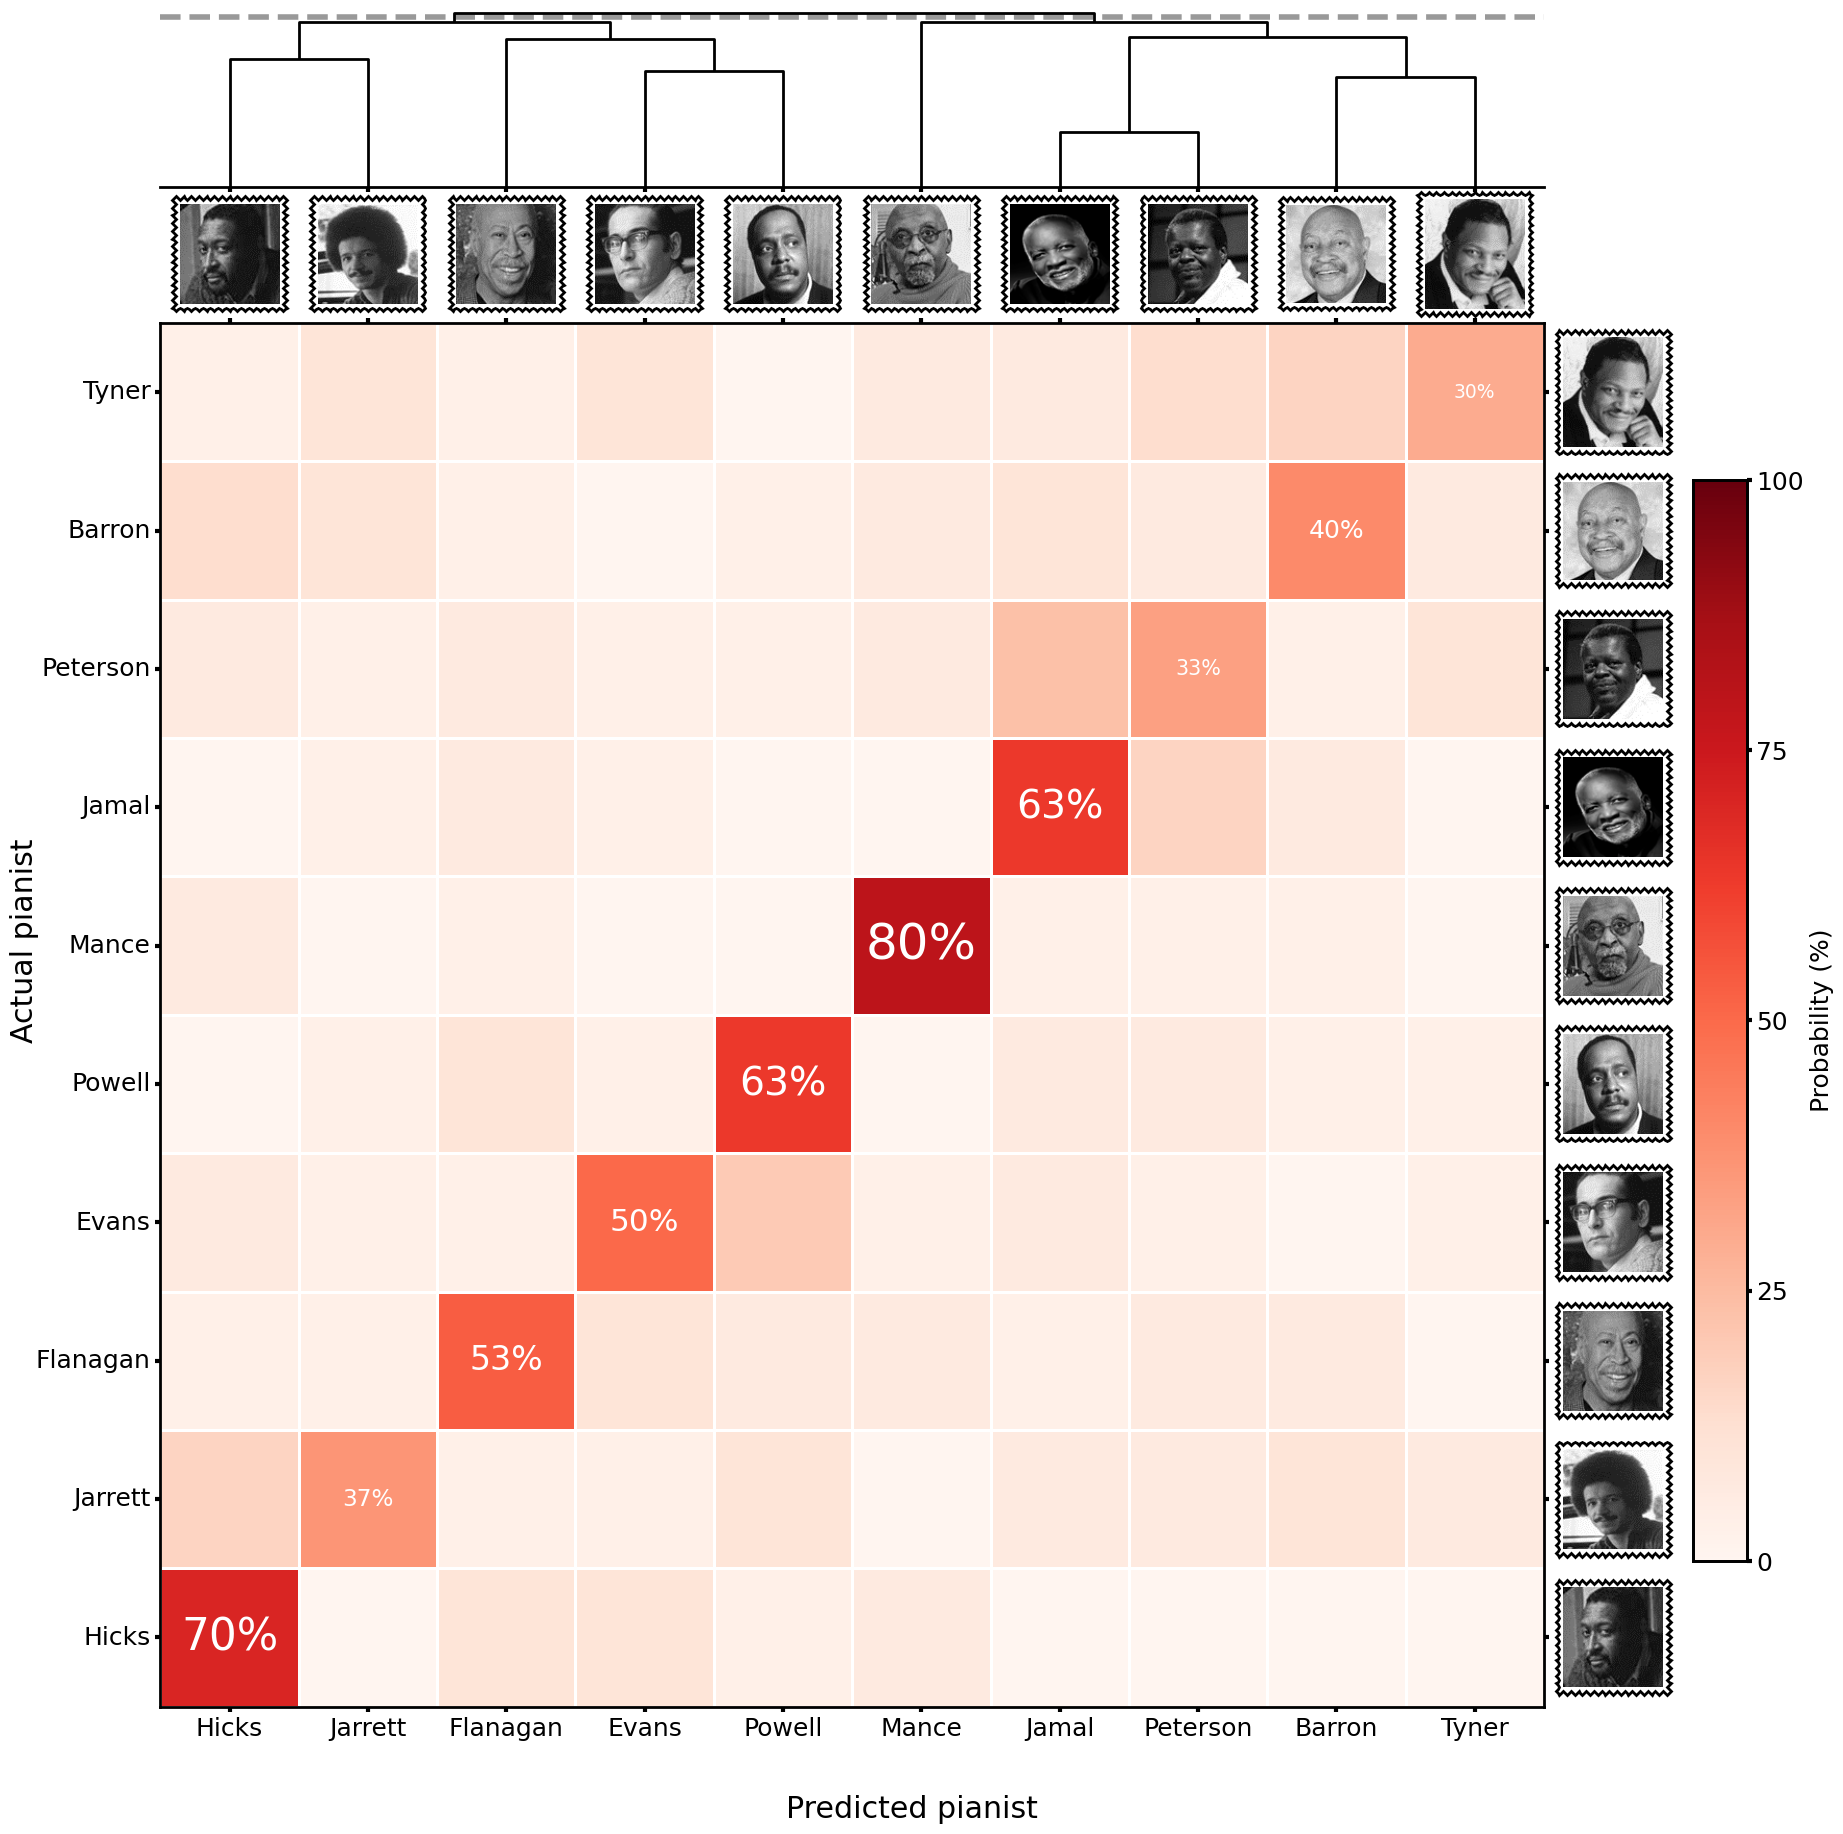

In [238]:
HeatMapPredictionProbDendro(rf_opt.predicts).create_plot()
plt.show()

### Get accuracy scores
Mean accuracy, top-k (`k=3`) accuracy, Cohen's kappa

In [29]:
from sklearn.metrics import top_k_accuracy_score, accuracy_score, cohen_kappa_score, confusion_matrix
act = rf_opt.predicts['actual'].map({v: k for k, v in enumerate(rf_opt.predicts['actual'].unique())}).values
pred = rf_opt.predicts['prediction'].map({v: k for k, v in enumerate(rf_opt.predicts['actual'].unique())}).values
probs = rf_opt.predicts[pianist_labels].values
print('Mean accuracy:', accuracy_score(act, pred))
print('Top-k accuracy:', top_k_accuracy_score(act, probs, k=3))
print('Cohen kappa:', cohen_kappa_score(act, pred))

Mean accuracy: 0.52
Top-k accuracy: 0.76
Cohen kappa: 0.4666666666666668


In [32]:
cm = pd.DataFrame(confusion_matrix(act, pred, normalize='true'))
cm.index = pianist_labels
cm.columns = pianist_labels
cm

,Ahmad Jamal,Bill Evans,Bud Powell,John Hicks,Junior Mance,Keith Jarrett,Kenny Barron,McCoy Tyner,Oscar Peterson,Tommy Flanagan
Ahmad Jamal,0.633333,0.033333,0.000000,0.000000,0.000000,0.033333,0.066667,0.000000,0.166667,0.066667
Bill Evans,0.066667,0.500000,0.200000,0.066667,0.033333,0.033333,0.000000,0.033333,0.033333,0.033333
Bud Powell,0.066667,0.033333,0.633333,0.000000,0.000000,0.033333,0.033333,0.033333,0.066667,0.100000
John Hicks,0.000000,0.100000,0.033333,0.700000,0.066667,0.000000,0.000000,0.000000,0.000000,0.100000
Junior Mance,0.033333,0.000000,0.000000,0.066667,0.800000,0.000000,0.033333,0.000000,0.033333,0.033333
Keith Jarrett,0.066667,0.033333,0.100000,0.166667,0.000000,0.366667,0.100000,0.066667,0.066667,0.033333
Kenny Barron,0.100000,0.000000,0.033333,0.133333,0.066667,0.100000,0.400000,0.066667,0.066667,0.033333
McCoy Tyner,0.066667,0.100000,0.000000,0.033333,0.066667,0.100000,0.166667,0.300000,0.133333,0.033333
Oscar Peterson,0.233333,0.033333,0.033333,0.066667,0.066667,0.033333,0.033333,0.100000,0.333333,0.066667
Tommy Flanagan,0.033333,0.100000,0.066667,0.033333,0.066667,0.033333,0.066667,0.000000,0.066667,0.533333


### Get feature importances
Average importance per feature, per category

In [38]:
imp_feat = (
    rf_opt.importances.copy(deep=True)
    .melt(id_vars=['feature', 'category'])
    .groupby('feature')
    ['value']
    .mean()
    .sort_values()
)
print(imp_feat * 100)

feature
coupling_drums               1.000000
coupling_bass                1.100000
coupling_piano_bass          1.633333
self_coupling                1.633333
bur_log_std                  2.000000
lz77_mean                    2.000000
coupling_piano_drums         2.233333
lz77_std                     2.400000
tempo                        2.966667
n_onsets_std                 3.000000
drums_prop_async_nanstd      3.500000
bass_prop_async_nanmean      3.566667
n_onsets_mean                3.600000
tempo_slope                  4.366667
rolling_std_median           6.000000
bass_prop_async_nanstd       6.400000
bur_log_mean                 8.300000
drums_prop_async_nanmean    10.666667
Name: value, dtype: float64


In [39]:
imp_cat = (
    rf_opt.grouped_importances.copy(deep=True)
    .mean(axis=1)
    .sort_values(ascending=True)
)
print(imp_cat * 100)

Interaction     5.866667
Swing           9.733333
Tempo          11.533333
Complexity     16.433333
Feel           21.466667
dtype: float64


## Predicting first and last recordings

In [142]:
X = clean[PREDICTORS].fillna(clean[PREDICTORS].mean())
# We can store the labels for later use
pianist_labels = clean[PREDICTION].unique().tolist()
y = clean[PREDICTION].map({val: i for i, val in enumerate(pianist_labels)})

In [143]:
clean['recording_year_'] = clean['recording_year'].astype(int)

In [150]:
min_idxs = (
    clean.sort_values(by=['pianist', 'recording_year_', 'mbz_id'], ascending=True)
    .groupby('pianist')
    .head(6)
    .index
    .sort_values()
    .to_numpy()
)
max_idxs = (
    clean.sort_values(by=['pianist', 'recording_year_', 'mbz_id'], ascending=False)
    .groupby('pianist')
    .head(6)
    .index
    .sort_values()
    .to_numpy()
)

In [151]:
def minmax_acc(test_idx) -> float:
    train_idx = np.sort(np.array([*(set(X.index) - set(test_idx))]))
    assert not set(test_idx).issubset(set(train_idx))
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    # Create the random forest model
    rf_fl = RandomForestClassifier(random_state=SEED, **BEST_PARAMS)
    # Fit the random forest to the training data
    rf_fl.fit(X_train, y_train)
    fl_pred = rf_fl.predict(X_test)
    # Get accuracy for predicting the set
    return accuracy_score(y_test, fl_pred)

min_acc = minmax_acc(min_idxs)
max_acc = minmax_acc(max_idxs)
print(min_acc, max_acc)

0.4 0.4666666666666667


In [146]:
def permute_model(rand_state):
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=rand_state)
    # Create the random forest model
    rf_rand = RandomForestClassifier(random_state=SEED, **BEST_PARAMS)
    # Fit the random forest to the training data
    rf_rand.fit(X_train, y_train)
    rand_pred = rf_rand.predict(X_test)
    return accuracy_score(y_test, rand_pred)

In [147]:
with Parallel(n_jobs=-1, verbose=5) as parallel:
    accs = parallel(delayed(permute_model)(state) for state in range(vutils.N_BOOT))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   27.6s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:   37.8s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   49.6s
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 858 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1434 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 2154 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 2568 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 3018 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 3504 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 4584 tasks      | e

In [149]:
np.std(accs)

0.05789692409311953

C:\Users\huwch\AppData\Local\Temp\ipykernel_20548\2095453251.py:54: UserWarning: FixedFormatter should only be used together with FixedLocator
  a.set(


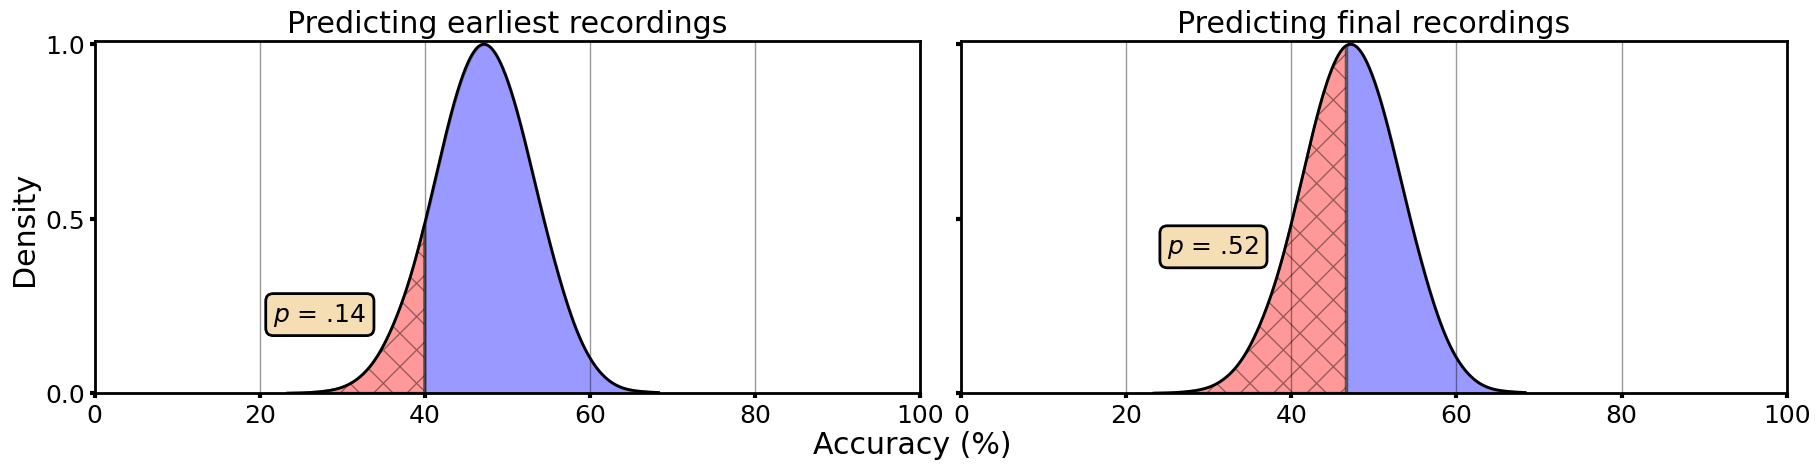

In [281]:
HistPlotFirstLastP(accs, min_acc, max_acc).create_plot()
plt.show()

## Regressions of age vs strongest predictors

In [93]:
clean['recording_year_'] = clean['recording_year'].astype(int)
clean['career_progress'] = clean.groupby('pianist')['recording_year_'].transform(lambda g: g - g.min())
clean['career_progress'] /= clean['career_progress'].max()
clean['jazz_progress'] = clean['recording_year_'] - clean['recording_year_'].min()
clean['jazz_progress'] /= clean['jazz_progress'].max()

In [96]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

predictors = ['drums_prop_async_nanmean', 'tempo_slope', 'bur_log_mean', 'n_onsets_mean', 'coupling_piano_drums']
conr = []
marr = []
for predict in predictors:
    vars_ = [predict, 'pianist', 'career_progress', 'jazz_progress']
    data = clean.copy(deep=True)
    data[predict] = data[predict].fillna(data[predict].mean())
    md = smf.mixedlm(f'{predict}~career_progress', groups=data['pianist'], data=data, re_formula='~career_progress').fit(method=['lbfgs'])
    print(md.summary())
    # Variance explained by the fixed effects: we need to use md.predict() with the underlying data to get this
    var_fixed = md.predict().var()
    # Variance explained by the random effects
    var_random = float(md.cov_re.to_numpy().mean())
    # Variance of the residuals
    var_resid = md.scale
    # Total variance of the model
    total_var = var_fixed + var_random + var_resid
    # Calculate the r2 values and append to the model
    conr.append((var_fixed + var_random) / total_var)
    marr.append(var_fixed / total_var)
print('mean conditional r2', np.mean(conr) * 100, 'stdev', np.std(conr) * 100)
print('mean marginal r2', np.mean(marr) * 100, 'stdev', np.std(marr) * 100)

                Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: drums_prop_async_nanmean
No. Observations: 300     Method:             REML                    
No. Groups:       10      Scale:              0.0000                  
Min. group size:  30      Log-Likelihood:     1100.4431               
Max. group size:  30      Converged:          Yes                     
Mean group size:  30.0                                                
----------------------------------------------------------------------
                            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------
Intercept                    0.015    0.002  8.998 0.000  0.012  0.018
career_progress             -0.003    0.004 -0.691 0.489 -0.010  0.005
Group Var                    0.000    0.002                           
Group x career_progress Cov -0.000    0.005                           
career_progress Var    

In [52]:
clean.groupby('pianist')['recording_year_'].describe()

,count,mean,std,min,25%,50%,75%,max
pianist,,,,,,,,
Ahmad Jamal,30.0,1970.400000,14.977224,1955.0,1960.00,1965.5,1970.75,2004.0
Bill Evans,30.0,1966.466667,7.050230,1956.0,1960.00,1965.5,1972.00,1980.0
Bud Powell,30.0,1955.600000,4.013769,1950.0,1952.25,1955.0,1959.75,1962.0
John Hicks,30.0,1994.400000,7.029985,1981.0,1990.00,1995.0,2000.25,2006.0
Junior Mance,30.0,1986.266667,16.911399,1960.0,1963.75,1994.5,1997.75,2007.0
Keith Jarrett,30.0,1986.733333,11.643952,1967.0,1977.75,1989.5,1994.00,2009.0
Kenny Barron,30.0,1994.333333,10.056164,1982.0,1984.00,1992.5,2003.00,2015.0
McCoy Tyner,30.0,1980.100000,11.299527,1962.0,1975.00,1978.0,1988.50,1998.0
Oscar Peterson,30.0,1965.233333,6.775632,1947.0,1961.00,1964.0,1970.00,1984.0


In [94]:
import seaborn as sns
class RegPlotCareerJazzProgress(vutils.BasePlot):
    predictors = ['drums_prop_async_nanmean', 'tempo_slope', 'bur_log_mean', 'n_onsets_mean', 'coupling_piano_drums']
    palette = sns.color_palette('tab10')
    palette = [palette[2], palette[4], palette[0], palette[1],   palette[3]]
    markers = ['o', 's', 'D', '^', 'p']
    categories = ['Feel', 'Tempo', 'Swing', 'Complexity', 'Interaction']
    REG_KWS = dict(color=vutils.BLACK, linewidth=vutils.LINEWIDTH * 2, ls=vutils.LINESTYLE)
    xspace = np.linspace(0, 1, 100)
    N_JOBS = -1

    def __init__(self, model_df, cat_mapping, **kwargs):
        self.corpus_title = 'corpus_chronology'
        self.cat_mapping = cat_mapping
        self.df = model_df.copy(deep=True)
        super().__init__(
            figure_title=fr'random_forest_plots\regplot_careerjazzprogress_{self.corpus_title}', **kwargs
        )
        self.fig, self.ax = plt.subplots(
            nrows=2, ncols=3, figsize=(vutils.WIDTH, vutils.WIDTH / 2), sharex=True, sharey=False
        )
        self.ax.flatten()[-1].axis('off')

    def get_line(self, model, mean):
        params = model.params
        intercept = params['Intercept']
        jp = params['jazz_progress'] * mean
        return [intercept + jp + (i * params['career_progress']) for i in self.xspace]

    @staticmethod
    def fit_model(data_, predict_):
        return (
            smf.mixedlm(
                f'{predict_}~career_progress+jazz_progress',
                groups=data_['pianist'],
                data=data_,
                re_formula='~jazz_progress'
            ).fit(method=['lbfgs'])
        )

    def bootstrap(self, data_, predict_) -> pd.DataFrame:
        def shuffle_data_and_fit(state):
            samp = data_.sample(frac=1, replace=True, random_state=state)
            mode = self.fit_model(samp, predict_)
            return pd.Series(self.get_line(mode, np.mean(samp['jazz_progress'])))

        with Parallel(n_jobs=self.N_JOBS, verbose=3) as par:
            boots = par(delayed(shuffle_data_and_fit)(num) for num in range(100))
        boot_ys = pd.concat(boots, axis=1)
        low = boot_ys.apply(lambda r: np.percentile(r, 2.5), axis=1)
        high = boot_ys.apply(lambda r: np.percentile(r, 97.5), axis=1)
        return pd.DataFrame(dict(x=self.xspace, low=low, high=high))

    def _create_plot(self):
        for ax, predict, col, mark in zip(self.ax.flatten(), self.predictors, self.palette, self.markers):
            data = self.df.copy(deep=True)
            data[predict] = data[predict].fillna(data[predict].mean())
            md = self.fit_model(data, predict)
            sns.scatterplot(
                data=data, x='career_progress', y=predict, label=self.cat_mapping[predict],
                ax=ax, color=col, marker=mark, s=100, alpha=vutils.ALPHA
            )
            results_y = pd.DataFrame(self.get_line(md, np.mean(data['jazz_progress'])))
            ax.plot(self.xspace, results_y, **self.REG_KWS)
            boot_df = self.bootstrap(data, predict)
            ax.fill_between(boot_df['x'], boot_df['low'], boot_df['high'], color=vutils.BLACK, alpha=vutils.ALPHA)

    def _format_ax(self):
        leg, hand = [], []
        for a, tit, col in zip(self.ax.flatten(), self.categories, self.palette):
            l, h = a.get_legend_handles_labels()
            leg.extend(l)
            hand.extend(h)
            a.get_legend().remove()
            a.grid(axis='x', which='major', **vutils.GRID_KWS)
            a.set_title(tit, color=col)
            a.set_ylabel(COL_MAPPING[a.get_ylabel()], color=col)
            a.set(xlabel='', xlim=(-0.05, 1.05))
            plt.setp(a.spines.values(), linewidth=vutils.LINEWIDTH)
            a.tick_params(axis='both', bottom=True, width=vutils.TICKWIDTH)
        self.fig.legend(
            leg, hand, loc='lower right', title='Category', frameon=True,
            framealpha=1, edgecolor=vutils.BLACK, bbox_to_anchor=(0.9, 0.15)
        )

    def _format_fig(self):
        self.fig.supxlabel('Career progress')
        self.fig.subplots_adjust(left=0.07, right=0.99, bottom=0.1, top=0.95, wspace=0.25)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   16.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   15.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   14.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   14.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.4s
C:\Python Projects\ja

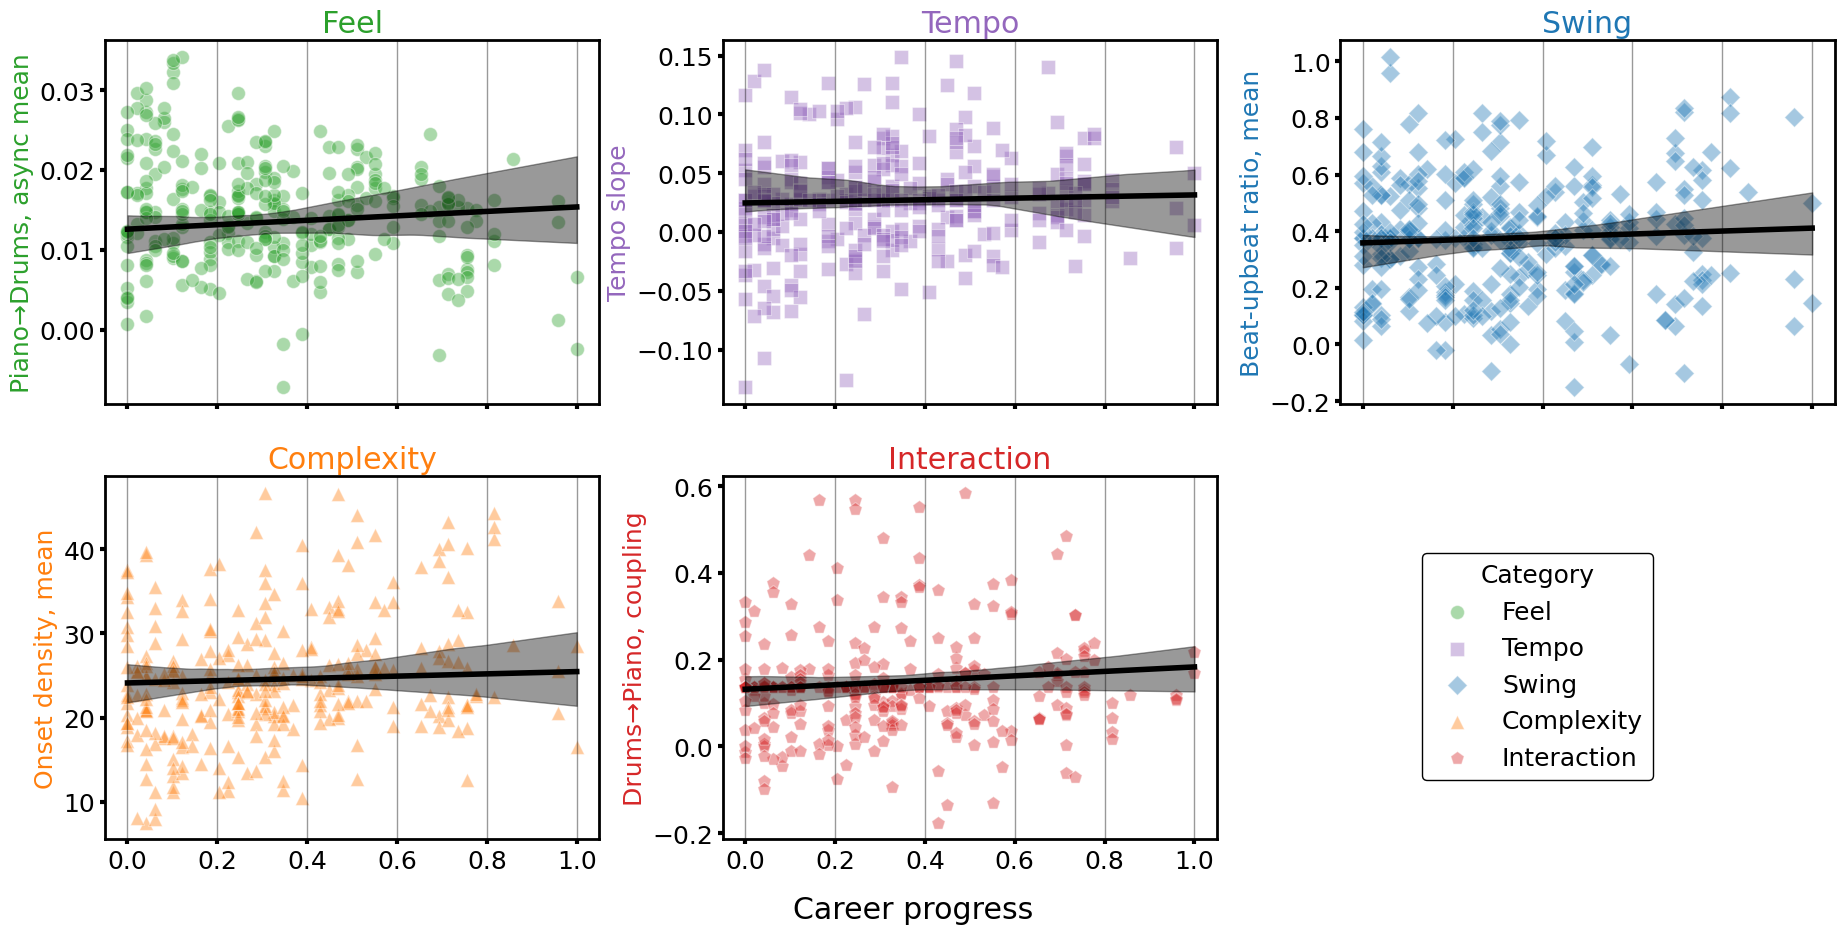

In [95]:
RegPlotCareerJazzProgress(clean, CATEGORY_MAPPING).create_plot()
plt.show()

## Binary logistic regression of two clusters -- impressionistic vs blues

In [43]:
impression = ['Bill Evans', 'Bud Powell', 'John Hicks', 'Keith Jarrett', 'Tommy Flanagan']
bop = ['Ahmad Jamal', 'Junior Mance', 'Kenny Barron', 'McCoy Tyner', 'Oscar Peterson']

In [44]:
clean.loc[clean['pianist'].isin(impression), 'cluster'] = 0
clean.loc[clean['pianist'].isin(bop), 'cluster'] = 1

In [45]:
X = clean[reversed([
    'bass_prop_async_nanmean',
    'bass_prop_async_nanstd',
    'drums_prop_async_nanmean',
    'drums_prop_async_nanstd',
    'tempo',
    'tempo_slope',
    'rolling_std_median',
    'bur_log_mean',
    'bur_log_std',
    'n_onsets_mean',
    'n_onsets_std',
    'lz77_mean',
    'lz77_std',
    'self_coupling',
    'coupling_bass',
    'coupling_drums',
    'coupling_piano_bass',
    'coupling_piano_drums'
])]
X = X.fillna(X.mean()).apply(stats.zscore)
X = sm.add_constant(X)
y = clean['cluster'].astype(int)

In [46]:
pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns)

const                       1.000000
coupling_piano_drums        1.434279
coupling_piano_bass         1.323919
coupling_drums              2.600280
coupling_bass               2.337764
self_coupling               1.439762
lz77_std                    5.806209
lz77_mean                   8.318691
n_onsets_std                5.539431
n_onsets_mean               9.179470
bur_log_std                 2.076519
bur_log_mean                1.989205
rolling_std_median          1.802553
tempo_slope                 1.233649
tempo                       4.879061
drums_prop_async_nanstd     2.060715
drums_prop_async_nanmean    1.380414
bass_prop_async_nanstd      2.104180
bass_prop_async_nanmean     1.474937
dtype: float64

In [47]:
md = sm.Logit(y, X).fit()
print(md.summary())

Optimization terminated successfully.
         Current function value: 0.527371
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                cluster   No. Observations:                  300
Model:                          Logit   Df Residuals:                      281
Method:                           MLE   Df Model:                           18
Date:                Thu, 14 Dec 2023   Pseudo R-squ.:                  0.2392
Time:                        13:38:39   Log-Likelihood:                -158.21
converged:                       True   LL-Null:                       -207.94
Covariance Type:            nonrobust   LLR p-value:                 2.775e-13
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        0.0012      0.138      0.009      0.993      -0.270

In [48]:
y_pred = md.predict(X)
print(accuracy_score(y, y_pred.round().astype(int)))
print(roc_auc_score(y, y_pred))
print(roc_auc_score(y, np.random.choice([0, 1], 300)))

0.72
0.8164444444444445
0.44333333333333336


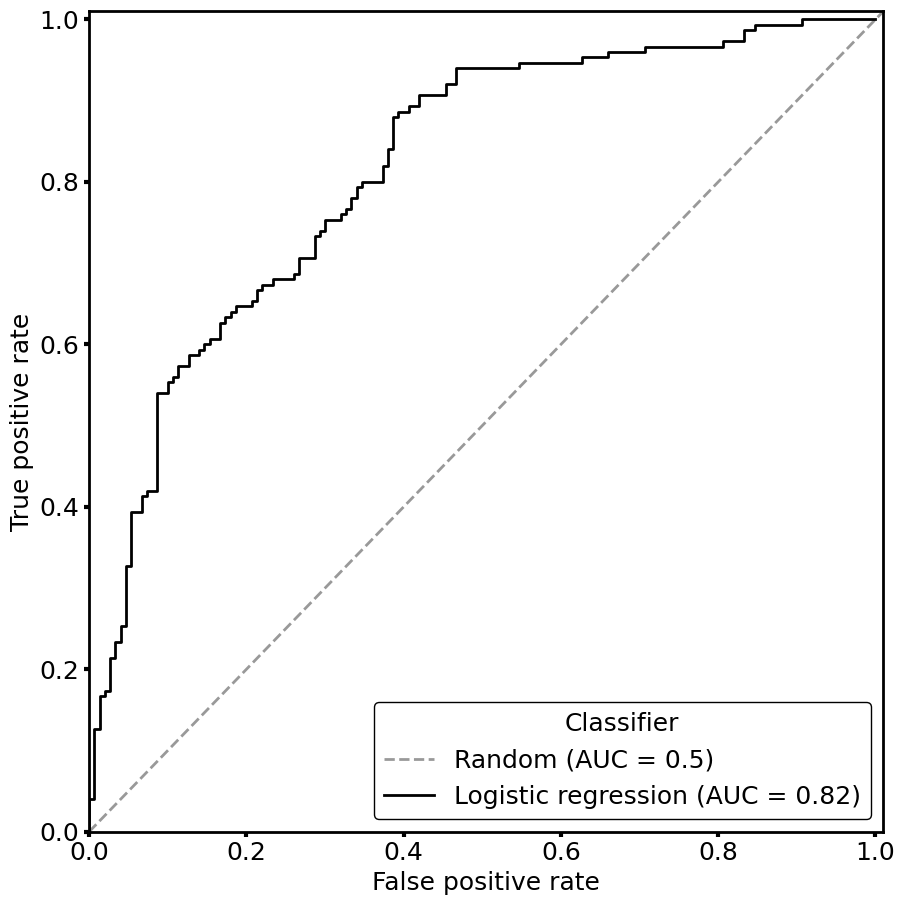

In [49]:
RocPlotLogRegression(y, y_pred).create_plot()
plt.show()

In [50]:
params = pd.concat([md.params.rename('coeff'), md.conf_int().rename(columns={0: 'low', 1: 'high'})], axis=1).apply(np.exp).reset_index(drop=False)[1:]
# params['low'] = params['coeff'] - params['low']
# params['high'] -= params['coeff']
params['category'] = params['index'].map(CATEGORY_MAPPING)

In [51]:
params

,index,coeff,low,high,category
1,coupling_piano_drums,0.876593,0.634122,1.211779,Interaction
2,coupling_piano_bass,1.661278,1.180680,2.337505,Interaction
3,coupling_drums,0.565610,0.353147,0.905897,Interaction
4,coupling_bass,0.455603,0.287301,0.722496,Interaction
5,self_coupling,1.893174,1.268086,2.826390,Interaction
6,lz77_std,1.519404,0.770156,2.997560,Complexity
7,lz77_mean,0.245566,0.103210,0.584271,Complexity
8,n_onsets_std,1.027802,0.508220,2.078582,Complexity
9,n_onsets_mean,6.460698,2.378831,17.546694,Complexity
10,bur_log_std,0.991520,0.669062,1.469388,Swing


C:\Users\huwch\AppData\Local\Temp\ipykernel_23432\2932596749.py:63: UserWarning: FixedFormatter should only be used together with FixedLocator
  self.ax.set(


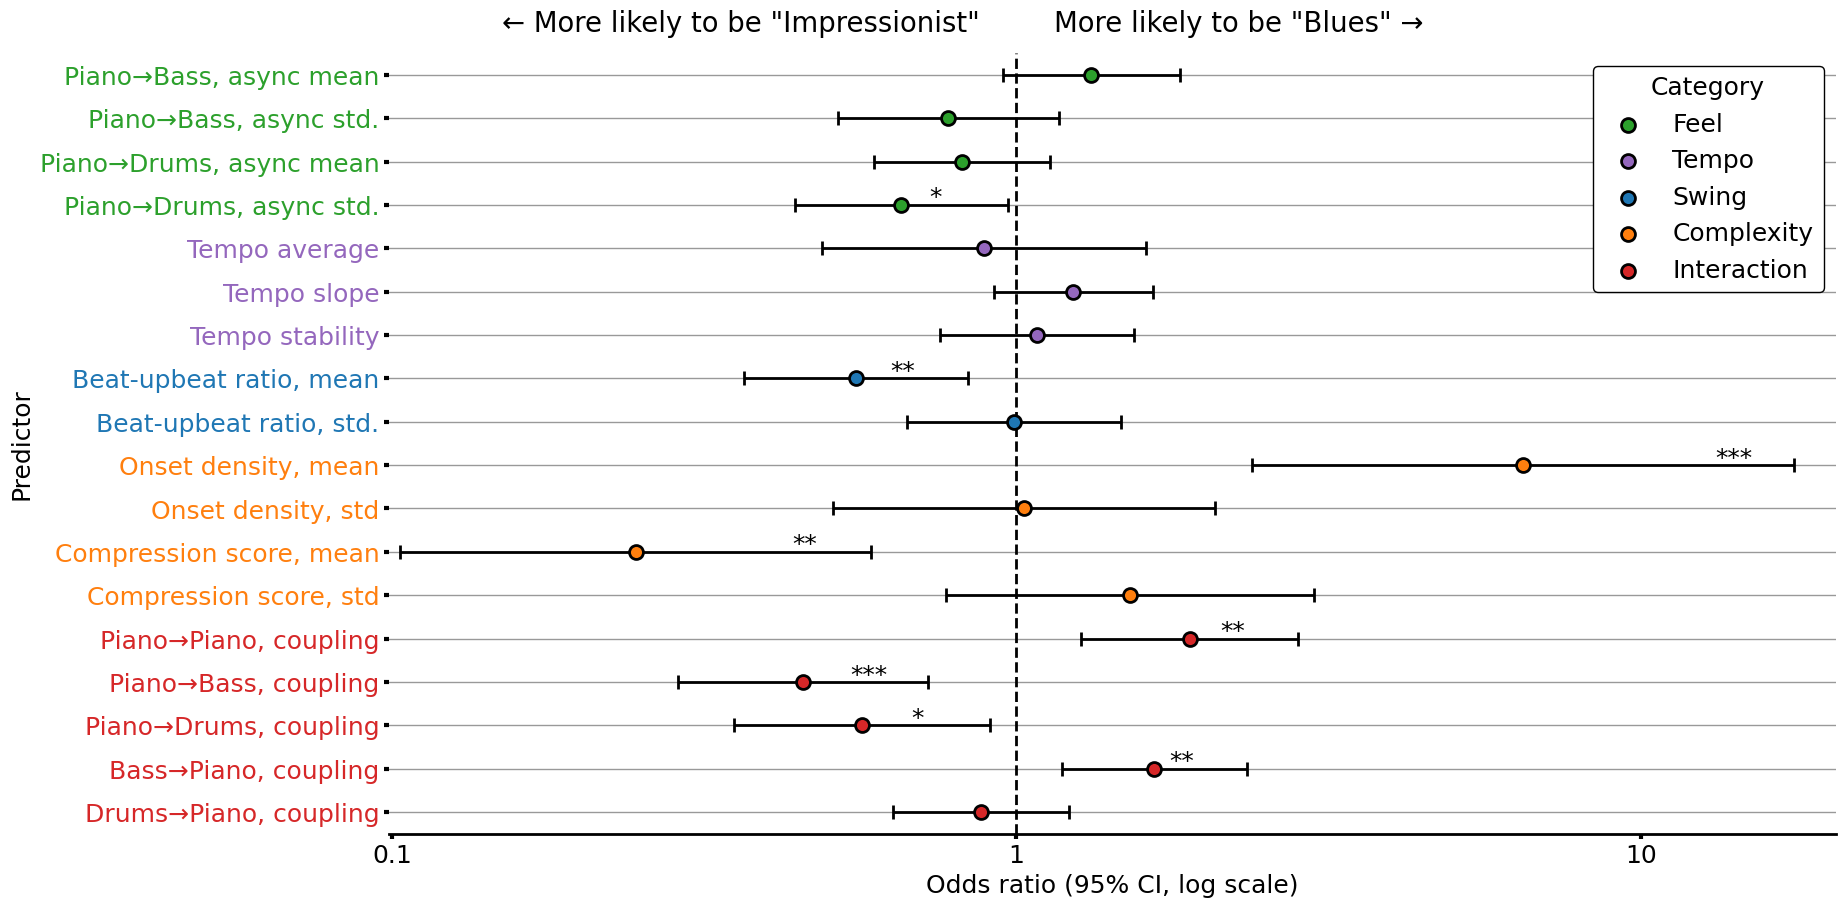

In [52]:
StripPlotLogitCoeffs(md, category_mapping=CATEGORY_MAPPING).create_plot()
plt.show()